# Inversion

In this notebook we demonstrate running an inversion with SimPEG for the coupling coefficient. 

There are two important conventions that differ between these codes: 
- **coordinate system**: SimPEG uses a right-handed coordinate system with z-positive up, while E3D uses a left-handed coordinate system with z-positive down. Therefore, we need to multiply the currents that we read in by -1
- **fourier convention**: SimPEG uses the $+i\omega t$ convention, whereas E3D uses the $-i\omega t$ convention, so we multiply the imaginary component by -1 to compare outputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
from scipy.spatial import cKDTree
from string import ascii_lowercase

import discretize 

from simpeg import (
    maps,
    Data,
    data_misfit, 
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
) 

import spcsem
from simpeg.electromagnetics import frequency_domain as fdem

set the default solver. Should ideally be Pardiso (obtained by installing `pydiso`) or Mumps (obtained by installing `pymumps`)

In [2]:
Solver = utils.solver_utils.get_default_solver()
Solver

pymatsolver.direct.pardiso.Pardiso

## read in E3D files 
- mesh
- conductivity model
- current density
- simulated data

In [3]:
mesh = discretize.TreeMesh.read_UBC("../e3d/J/octree_mesh_casing.txt")
conductivity_model = discretize.TreeMesh.read_model_UBC(mesh, "../e3d/J/model_casing.con")

In [4]:
jx_e3d = np.loadtxt("../e3d/J/J_X.txt")
jy_e3d = np.loadtxt("../e3d/J/J_Y.txt")
jz_e3d = np.loadtxt("../e3d/J/J_Z.txt")

In [5]:
jx = spcsem.utils.match_values_nearest(jx_e3d, mesh.edges_x)
jy = spcsem.utils.match_values_nearest(jy_e3d, mesh.edges_y)
jz = spcsem.utils.match_values_nearest(jz_e3d, mesh.edges_z)

plot cross sections of the current density

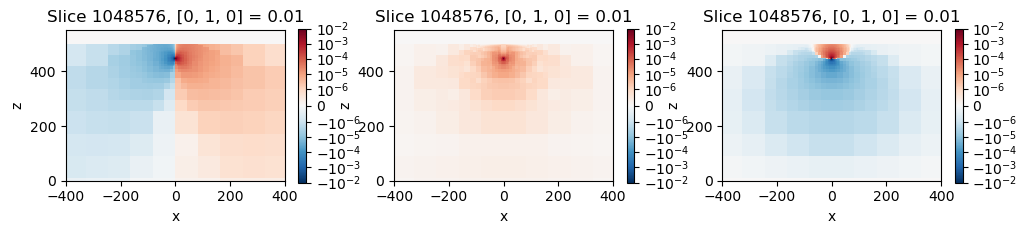

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))

for a, j, comp in zip(ax, [jx, jy, jz], ["x", "y", "z"]): 
    cb = plt.colorbar(mesh.plot_slice(
        getattr(mesh, f"average_edge_{comp}_to_cell") * j, 
        ax=a,
        normal="y", 
        pcolor_opts={"norm":SymLogNorm(vmin=-1e-2, vmax=1e-2, linthresh=1e-6), "cmap":"RdBu_r"},
    )[0], ax=a)
    a.set_xlim(np.r_[-1, 1]*400)
    a.set_ylim(np.r_[0, 550])
    a.set_aspect(1)

In [7]:
# load predicted data 
data_path = "../e3d/points"

In [8]:
data_locs = np.loadtxt(f"{data_path}/points.txt")
data_e3d = np.loadtxt(f"{data_path}/dpredFWD.txt")

In [9]:
data_e3d_x = data_e3d[::2, :]
data_e3d_y = data_e3d[1::2, :]

In [10]:
rx_x = np.unique(data_locs[:, 0])
rx_y = np.unique(data_locs[:, 1])

plot data from E3D

# setup simulation 

parameters used for the E3D simulation

In [11]:
gravity_acceleration = 9.81 
density_water = 1000.0 
coupling_coefficient = 1e-5
frequency = 1 

### define a halfspace model and model with anomalous coupling coefficients 

In [12]:
air_earth_interface = 500

In [13]:
halfspace = coupling_coefficient * np.ones(mesh.n_cells)

# set values in air to be 0 
halfspace[mesh.cell_centers[:, 2] > air_earth_interface] = 0 
true_model = halfspace.copy()

# add an anomalous block by point source (at 446m)
block_x = 30*np.r_[-1, 1]
block_y = block_x
block_z = np.r_[430, 460]  

coupling_coefficient_block = 1e-4 # one order of magnitude larger than background

# indices of the block 
inds_block = (
    (mesh.cell_centers[:, 0] > block_x.min()) & 
    (mesh.cell_centers[:, 0] < block_x.max()) & 
    (mesh.cell_centers[:, 1] > block_y.min()) & 
    (mesh.cell_centers[:, 1] < block_y.max()) & 
    (mesh.cell_centers[:, 2] > block_z.min()) & 
    (mesh.cell_centers[:, 2] < block_z.max()) 
)
true_model[inds_block] = coupling_coefficient_block

create a simpeg mapping to only invert for values in the subsurface and outside of the casing

In [14]:
subsurface_cells = mesh.cell_centers[:, 2] < air_earth_interface # all cells below 500m are active
casing_cells = (conductivity_model == np.max(conductivity_model))
active_cells = ~(subsurface_cells & casing_cells)

coupling_coefficient_map = (
    maps.InjectActiveCells(
        mesh=mesh,
        active_cells=active_cells,
        value_inactive= halfspace[~active_cells], # set coupling coefficient to 0 in air and use same value as subsurface for casing
    )
)

Text(0.5, 1.0, 'True coupling coefficient')

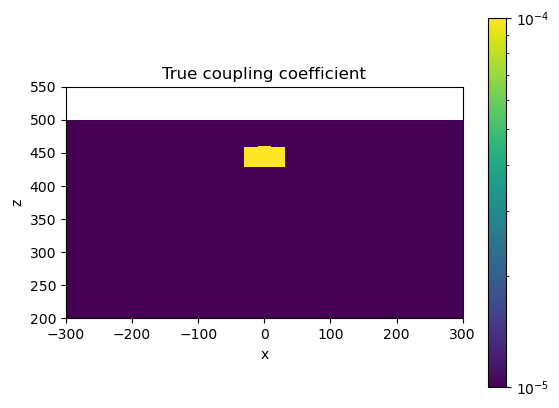

In [15]:
fig, ax = plt.subplots(1, 1)

cb = plt.colorbar(
    mesh.plot_slice(
        true_model,
        pcolor_opts={"norm":LogNorm()},
        normal="Y",
        ax=ax,
        # grid_opts={"color":"k", "lw":0.5}
    )[0], ax=ax
)

ax.set_xlim(np.r_[-1, 1]*300)
ax.set_ylim(np.r_[200, 550])
ax.set_aspect(1)
ax.set_title("True coupling coefficient")

### set up the survey and Jsp Source

The class `spcsem.JspSource` is a custom source class that takes a pore pressure gradient, frequency, density of water and gravity acceleration. The coupling coefficient will be provided by the simulation. This is so that later on, we can invert for the coupling coefficient. 

In [16]:
# create receiver list
rx_list = [
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="x", component="imag"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="real"),
    fdem.receivers.PointElectricField(locations=data_locs, orientation="y", component="imag"),
]

In [17]:
# source current density. We multiply by -1 because of the difference in coordinate systems 
jsrc = (
    -np.hstack([jx, jy, jz])
)

In [18]:
source = spcsem.JspSource(
    receiver_list=rx_list, 
    frequency=frequency,
    pore_pressure_gradient=1/(-coupling_coefficient / (density_water*gravity_acceleration)) * jsrc,
    density_water=density_water, 
    gravity_acceleration=gravity_acceleration,
)

In [19]:
survey = fdem.Survey([source])

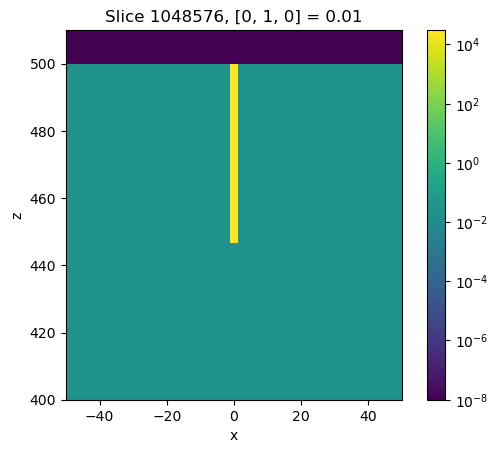

In [20]:
fig, ax = plt.subplots(1, 1)

plt.colorbar(mesh.plot_slice(
    conductivity_model,
    ax=ax,
    normal="Y",
    pcolor_opts={"norm":LogNorm()}
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*50)
ax.set_ylim(np.r_[400, 510])
ax.set_aspect(1)

In [21]:
sim = spcsem.Simulation3DElectricFieldSelfPotential(
    mesh=mesh, 
    survey=survey, 
    solver=Solver,
    sigma=conductivity_model, 
    coupling_coefficientMap=coupling_coefficient_map, 
    # storeJ=True
)

# simulate data with and without anomalous coupling coefficient
Make sure there is a difference in the data with / without anomalous block

In [22]:
%%time
data_halfspace = sim.make_synthetic_data(halfspace[active_cells])

/home/lheagy/miniforge3/envs/sp-csem-inv/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


CPU times: user 13min 36s, sys: 28.5 s, total: 14min 4s
Wall time: 46.3 s


In [23]:
%%time
data_target = sim.make_synthetic_data(true_model[active_cells])

CPU times: user 11min 57s, sys: 22.5 s, total: 12min 19s
Wall time: 40.9 s


In [24]:
def plot_data(data_object, subtract=None): 
    fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)

    for a, rx in zip(ax.flatten(), rx_list):
        dplot = data_object[source, rx].reshape(len(rx_x), len(rx_y), order="F")
        if subtract is not None: 
            dplot = dplot - subtract[source, rx].reshape(len(rx_x), len(rx_y), order="F")
        plt.colorbar(
            a.contourf(
                rx_x, rx_y, dplot, levels=50,
                cmap="jet"
            ), ax=a
        )
        orientation = "x" if rx.orientation[0] == 1 else "y"
        a.set_title(f"E{orientation} {rx.component}")
    
        a.set_aspect(1)
    return fig, ax

In [25]:
def plot_data_profile(data_object, subtract=None, color=None, ax=None, label=None): 
    if ax is None: 
        fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

    center_ind_y = int((len(rx_y)-1)/2)
    center_ind_x = int((len(rx_x)-1)/2)
    
    for a, rx in zip(ax.flatten(), rx_list):
        dplot = data_object[source, rx].reshape(len(rx_x), len(rx_y), order="F")
        if subtract is not None: 
            dplot = dplot - subtract[source, rx].reshape(len(rx_x), len(rx_y), order="F")
        
        orientation = "x" if rx.orientation[0] == 1 else "y"

        if orientation == "x":
            a.plot(rx_x, dplot[center_ind_y, :], color=color, label=label)
        elif orientation == "y":
            a.plot(rx_y, dplot[:, center_ind_x], color=color, label=label)
        a.set_title(f"E{orientation} {rx.component}")
    
        # a.set_aspect(1)
    return ax

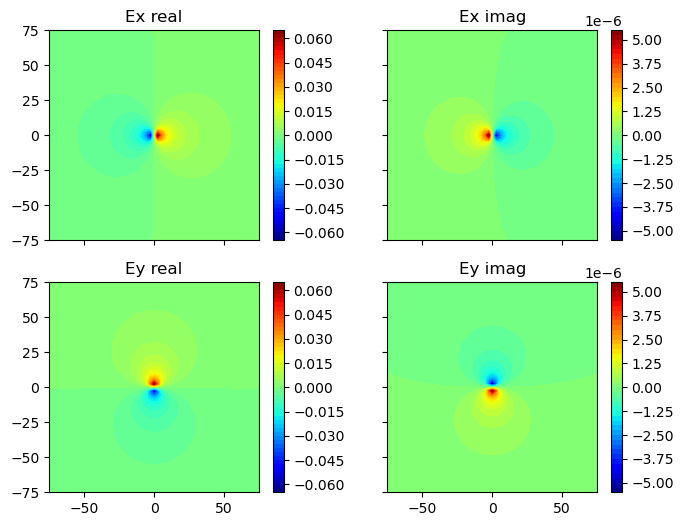

In [26]:
fig, ax = plot_data(data_halfspace)

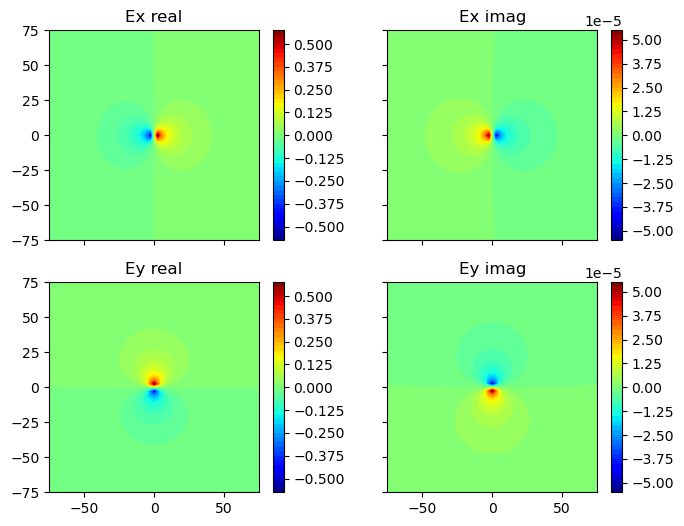

In [27]:
fig, ax = plot_data(data_target)

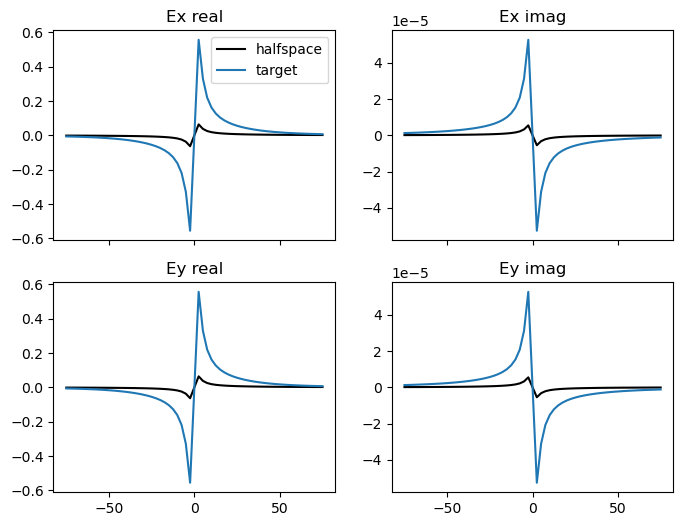

In [28]:
ax = plot_data_profile(data_halfspace, color="k", label="halfspace")
plot_data_profile(data_target, label="target", color="C0", ax=ax)
ax[0, 0].legend()

# set up inversion

In [29]:
# define uncertainties to be used in the inversion 
relative_error = 0.05  # fit within 5% 
noise_floor = 1e-7  # define "close enough" to zero

data_target.relative_error = relative_error
data_target.noise_floor = noise_floor

In [30]:
dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_target)
reg = regularization.WeightedLeastSquares(
    mesh, 
    active_cells=active_cells
)

set up the optimization. Here, we use projected Gauss Newton with Conjugate Gradient so that we can include a lower bound of zero to avoid negative coupling coefficients

In [31]:
opt = optimization.ProjectedGNCG(maxIter=20, lower=0)

inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [32]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)

cool_beta = directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)

# Update the preconditionner
update_Jacobi = directives.UpdatePreconditioner()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputDictEveryIteration(
    saveOnDisk=True,
)

target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [
    starting_beta,
    cool_beta,
    save_iteration,
    target_misfit,
]
    

In [33]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

In [34]:
m0 = halfspace[active_cells]
mrec = inv.run(m0)


Running inversion with SimPEG v0.24.1.dev15+ge44476b14
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.
simpeg.InvProblem will set Regularization.reference_model to m0.

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation3DElectricFieldSelfPotential problem***
                        
simpeg.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2025-07-09-09-46.npz'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     p

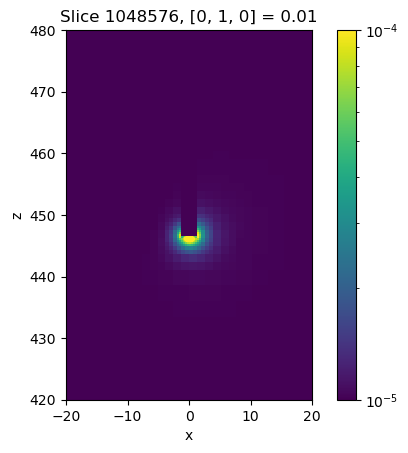

In [35]:
fig, ax = plt.subplots(1, 1) 

cb = plt.colorbar(mesh.plot_slice(
    sim.coupling_coefficientMap * mrec, #save_iteration.outDict[3]["m"], 
    normal="Y",
    pcolor_opts={"norm":LogNorm(vmin=1e-5, vmax=1e-4)},
    ax=ax
)[0], ax=ax)

ax.set_xlim(np.r_[-1, 1]*20)
ax.set_ylim(np.r_[420, 480])
ax.set_aspect(1)

In [36]:
dpred = Data(dobs=inv.invProb.dpred, survey=survey)

(<Figure size 800x600 with 8 Axes>,
 array([[<Axes: title={'center': 'Ex real'}>,
         <Axes: title={'center': 'Ex imag'}>],
        [<Axes: title={'center': 'Ey real'}>,
         <Axes: title={'center': 'Ey imag'}>]], dtype=object))

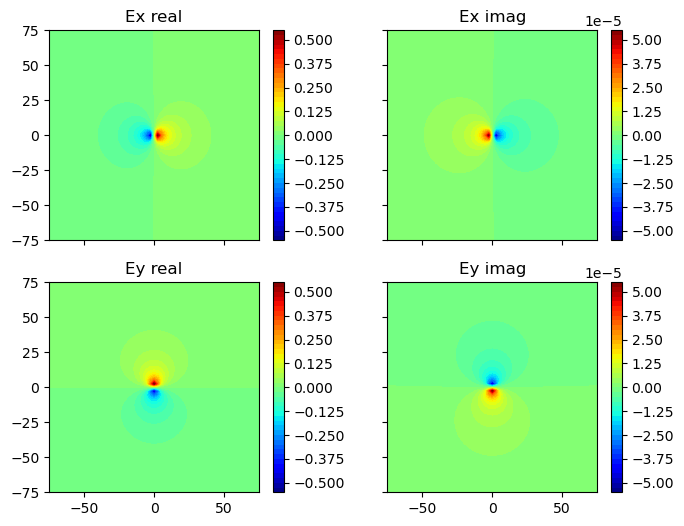

In [37]:
plot_data(dpred)

(<Figure size 800x600 with 8 Axes>,
 array([[<Axes: title={'center': 'Ex real'}>,
         <Axes: title={'center': 'Ex imag'}>],
        [<Axes: title={'center': 'Ey real'}>,
         <Axes: title={'center': 'Ey imag'}>]], dtype=object))

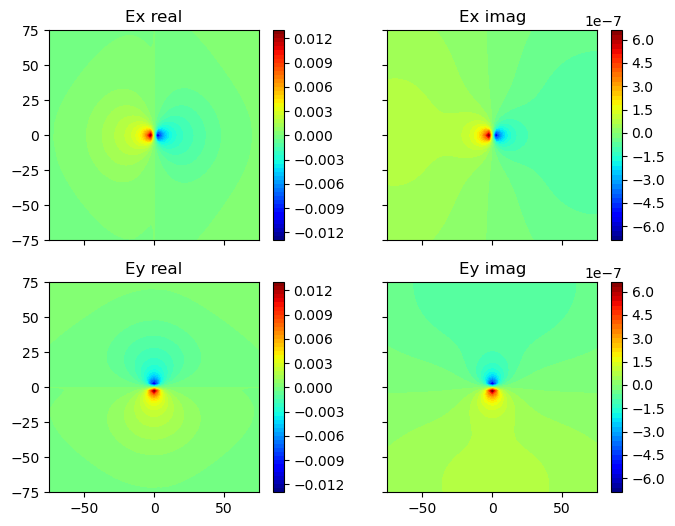

In [38]:
plot_data(dpred, subtract=data_target)

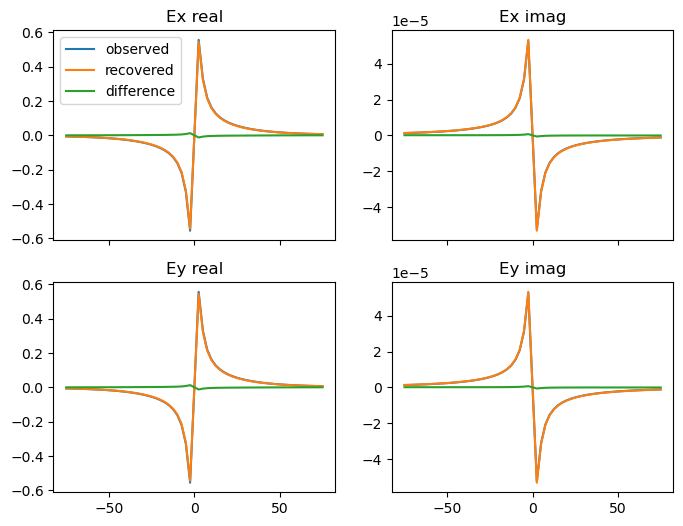

In [39]:
ax = plot_data_profile(data_target, color="C0", label="observed")
plot_data_profile(dpred, label="recovered", color="C1", ax=ax)
plot_data_profile(dpred, subtract=data_target, label="difference", color="C2", ax=ax)

ax[0, 0].legend()